Melhor solução segundo PROMETHEE I:
f1                    514.000000
f2                   1252.300650
Fluxo_Promethee_I       0.036395
Name: 5, dtype: float64

Melhor solução segundo ELECTRE I:
f1                  352.000000
f2                 1378.512141
Fluxo_Electre_I       7.000000
Name: 3, dtype: float64


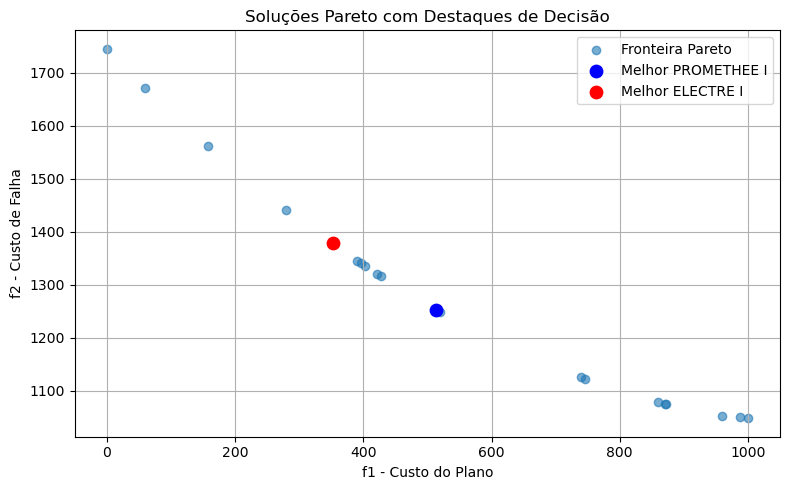

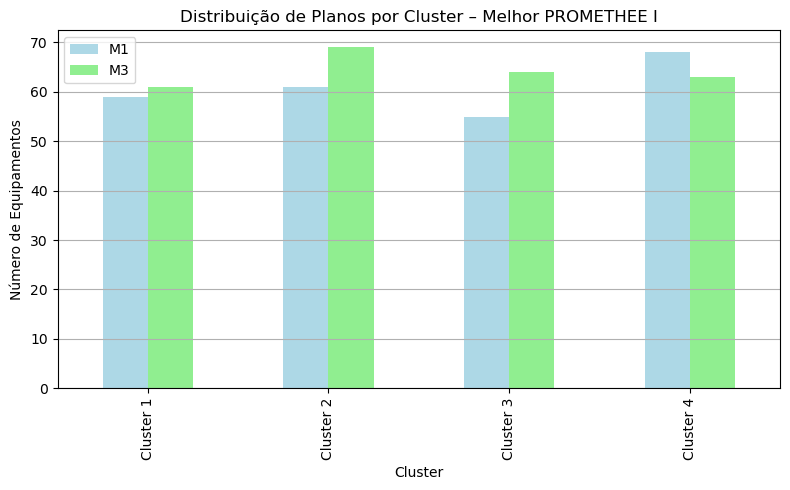

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# cores para os planos M1, M2 e M3
CORES_PLANOS = ["lightblue", "lightgreen", "lightpink"]
# nomes dos clusters (baseado no arquivo EquipDB.csv)
NOMES_CLUSTERS = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

# carrega os resultados da fronteira de Pareto
df_raw = pd.read_csv("resultados_pareto_somaPonderada_2025-06-01_02-07-02.csv")

# carrega informações de cluster de cada equipamento
# EquipDB.csv: col1=ID, col2=t0, col3=cluster, col4=custo falha
equip_db = pd.read_csv("arquivos_tc/EquipDB.csv", header=None)
cluster_ids = equip_db.iloc[:, 2].astype(int).values  # array de clusters (1 a 4)

# remove duplicatas estritas e obtém conjunto não-dominado
df_nd = df_raw.drop_duplicates(subset=["f1", "f2"]).reset_index(drop=True)

# normaliza f1 e f2 usando todo o conjunto não-dominado
denom_f1 = df_nd['f1'].max() - df_nd['f1'].min()
denom_f2 = df_nd['f2'].max() - df_nd['f2'].min()
if denom_f1 == 0 or denom_f2 == 0:
    raise ValueError("Não há variação em f1 ou f2 para normalizar")
df_nd['f1_norm'] = (df_nd['f1'] - df_nd['f1'].min()) / denom_f1
df_nd['f2_norm'] = (df_nd['f2'] - df_nd['f2'].min()) / denom_f2

# limita a 20 soluções (após normalização)
if len(df_nd) > 20:
    df = df_nd.sample(n=20, random_state=203).reset_index(drop=True)
else:
    df = df_nd.copy()

# matriz de decisão normalizada: [f1_norm, f2_norm]
matriz_decisao = df[['f1_norm','f2_norm']].values

# pesos iguais para f1 e f2
pesos = np.array([0.5, 0.5])

# PROMETHEE I: calcula fluxo de saída (phi+) e entrada (phi-)
def promethee_i(matriz, pesos):
    n = matriz.shape[0]
    pref = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            diff = np.maximum(0, matriz[j] - matriz[i])
            pref[i, j] = np.dot(pesos, diff)
    phi_plus = np.mean(pref, axis=1)
    phi_minus = np.mean(pref, axis=0)
    return phi_plus, phi_minus

# ELECTRE I: concordância e discordância simples
def electre_i(matriz, pesos, c_thresh=0.5, d_thresh=0.5):
    n, m = matriz.shape
    conc = np.zeros((n, n))
    disc = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            c_val, d_val = 0.0, 0.0
            for k in range(m):
                if matriz[i,k] <= matriz[j,k]:
                    c_val += pesos[k]
                else:
                    d_val = max(d_val, abs(matriz[i,k] - matriz[j,k]))
            conc[i,j], disc[i,j] = c_val, d_val
    outrank = (conc >= c_thresh) & (disc <= d_thresh)
    phi_plus = outrank.sum(axis=1)
    phi_minus = outrank.sum(axis=0)
    return phi_plus, phi_minus

# calcula fluxos e identifica melhores índices
prom_plus, prom_minus = promethee_i(matriz_decisao, pesos)
elec_plus, elec_minus = electre_i(matriz_decisao, pesos)

df['Fluxo_Promethee_I'] = prom_plus - prom_minus
df['Fluxo_Electre_I'] = elec_plus - elec_minus
best_prom_idx = df['Fluxo_Promethee_I'].idxmax()
best_elec_idx = df['Fluxo_Electre_I'].idxmax()

print("Melhor solução segundo PROMETHEE I:")
print(df.loc[best_prom_idx, ['f1','f2','Fluxo_Promethee_I']])
print("\nMelhor solução segundo ELECTRE I:")
print(df.loc[best_elec_idx, ['f1','f2','Fluxo_Electre_I']])

# plota fronteira e destaca escolhas
plt.figure(figsize=(8,5))
plt.scatter(df['f1'], df['f2'], label="Fronteira Pareto", alpha=0.6)
plt.scatter(df.loc[best_prom_idx,'f1'], df.loc[best_prom_idx,'f2'], color='blue', label="Melhor PROMETHEE I", s=80)
plt.scatter(df.loc[best_elec_idx,'f1'], df.loc[best_elec_idx,'f2'], color='red',  label="Melhor ELECTRE I",  s=80)
plt.xlabel("f1 - Custo do Plano")
plt.ylabel("f2 - Custo de Falha")
plt.title("Soluções Pareto com Destaques de Decisão")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# agora, para a solução escolhida (PROMETHEE I), plota distribuição por cluster
solucao = df.loc[best_prom_idx, df.columns.str.startswith('x')].astype(int).values
# cada solucao[i] é 1,2 ou 3; cluster_ids[i] é de 1 a 4

df_plot = pd.DataFrame({
    'Cluster': cluster_ids,
    'Plano': solucao
})
# crosstab: linhas=cluster, colunas=plano
freq = pd.crosstab(df_plot['Cluster'], df_plot['Plano'])
# renomeia índices e colunas
freq.index = NOMES_CLUSTERS
freq.columns = [f'M{col}' for col in freq.columns]

ax = freq.plot(kind='bar', color=CORES_PLANOS, figsize=(8,5))
ax.set_xlabel('Cluster')
ax.set_ylabel('Número de Equipamentos')
ax.set_title('Distribuição de Planos por Cluster – Melhor PROMETHEE I')
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()
